https://gist.github.com/rahulrajpl/36a5724d0c261b915292182b1d741393
https://www.kaggle.com/rahulrajpl/diffusion-map-for-manifold-learning
https://github.com/arashbehboodi/DiffusionMap/blob/master/diffusionmapmod.py

In [39]:
from scipy.linalg import eigh
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.datasets import fetch_openml
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [93]:
def diffmap(xs, sigma, t, m):
    W = np.exp(-euclidean_distances(xs, xs) ** 2 /(2 * (sigma ** 2)))
    
    ## d is a vector containing the row sums of W
    d = W.sum(axis=0)
    D_inv = np.diag(1/d)
    D_left = np.diag(d ** (-0.5))
    D_right = np.diag(d ** 0.5)
    
    M = D_inv @ W
    M_s = (D_right @ M) @ D_left
    
    ## M_s has nice real eigvecs and eigvals
    eigvals, eigvecs = eigh(M_s)
    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    Phi = D_left @ eigvecs
    Lambda = eigvals ** t
    
    diffusion_map = Phi @ np.diag(Lambda)
    diffusion_map_trunc = diffusion_map[:,1:(m + 1)]
     
#     diffusion_map_trunc = eigvecs[:,1:(m + 1)] @ np.diag(eigvals[1:(m + 1)]) 
    
    return diffusion_map_trunc

In [95]:
spiral = sio.loadmat("spiral.mat")["spiral"]

In [96]:
spiral.shape

(1000, 2)

In [97]:
thetas = sio.loadmat("spiral.mat")["thetas"]

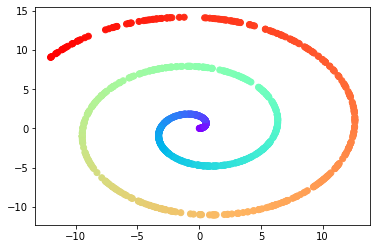

In [98]:
plt.scatter(spiral[:,0],spiral[:,1],c = thetas,cmap='rainbow')

In [99]:
diffusion_map_trunc = diffmap(spiral, 1, t = 100, m = 1)

In [100]:
diffusion_map_trunc.shape

(1000, 1)

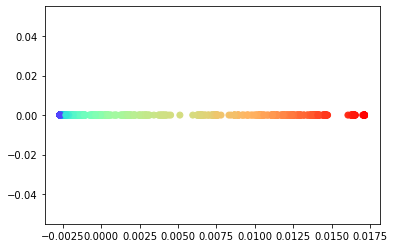

In [101]:
plt.scatter(diffusion_map_trunc[:], [0]*diffusion_map_trunc.shape[0],c=thetas,cmap ='rainbow')

In [102]:
digits_X = sio.loadmat("digits.mat")['X']
digits_y = sio.loadmat("digits.mat")['y']

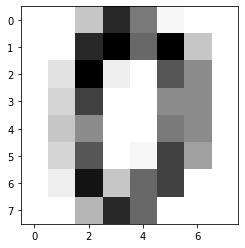

In [103]:
digits_sample = digits_X[0].reshape([8,8])
plt.imshow(digits_sample,cmap='Greys')

In [128]:
diffusion_map_trunc = diffmap(digits_X, sigma =5000, t = 50, m = 2)

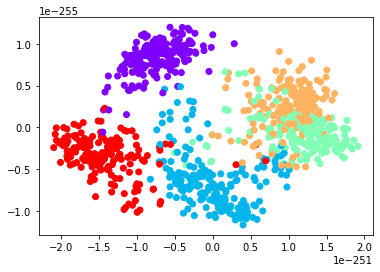

In [129]:
plt.scatter(diffusion_map_trunc[:,0], diffusion_map_trunc[:,1], c = digits_y, cmap ='rainbow')

In [162]:
digits_y[0:20]

array([[0],
       [1],
       [2],
       [3],
       [4],
       [0],
       [1],
       [2],
       [3],
       [4],
       [0],
       [1],
       [2],
       [3],
       [4],
       [0],
       [0],
       [4],
       [1],
       [3]], dtype=int64)

No handles with labels found to put in legend.


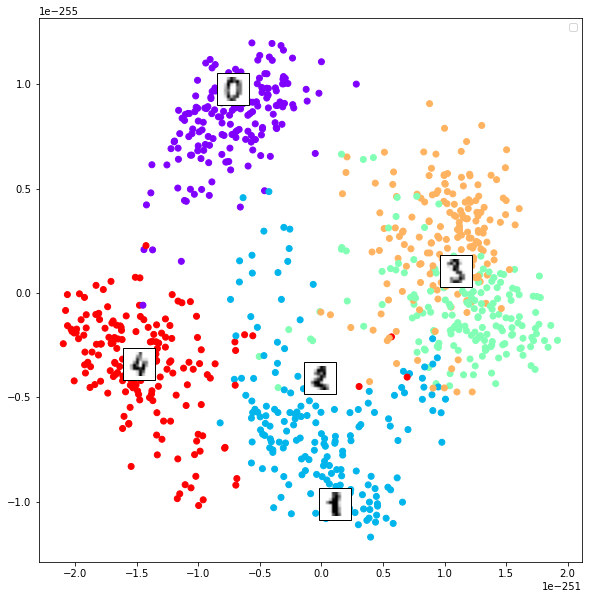

In [131]:
plt.figure(figsize=(12, 10))
    
ax = plt.subplot(aspect='equal')

plt.scatter(diffusion_map_trunc[:,0], diffusion_map_trunc[:,1], c = digits_y, cmap ='rainbow')

random_pos = np.random.randint(0,100)
for i in range(5):
    img = digits_X[i].reshape([8,8])
    img = OffsetImage(img, cmap=plt.cm.gray_r, zoom=3) 
    ax.add_artist(AnnotationBbox(img, (diffusion_map_trunc[i,0] , diffusion_map_trunc[i,1])))

plt.legend()
plt.show()

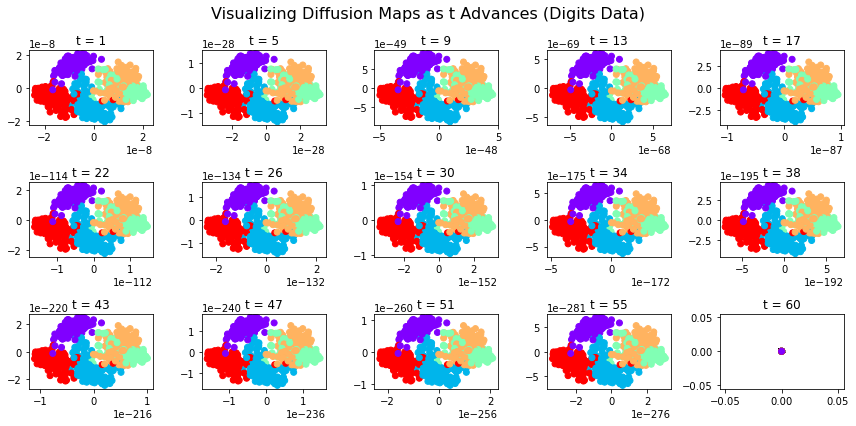

In [188]:
t_values = np.linspace(1, 60, 15, dtype=np.int32)
fig, axs = plt.subplots(3, 5, figsize = (12,6))
for i , ax in enumerate(axs.flatten()):
    diffusion_map_trunc = diffmap(digits_X, sigma =5000, t = t_values[i], m = 2)
    ax.scatter(diffusion_map_trunc[:,0], diffusion_map_trunc[:,1], c = digits_y, cmap ='rainbow')
    ax.axis('on')
    ax.set_title('t = ' + str(t_values[i]), fontsize=12)
fig.suptitle('Visualizing Diffusion Maps as t Advances (Digits Data)', fontsize=16)
plt.tight_layout()

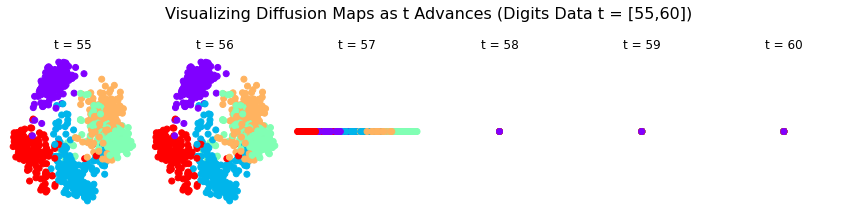

In [189]:
t_values = np.linspace(55, 60, 6, dtype=np.int32)
fig, axs = plt.subplots(1, 6, figsize = (12,3))
for i , ax in enumerate(axs.flatten()):
    diffusion_map_trunc = diffmap(digits_X, sigma =5000, t = t_values[i], m = 2)
    ax.scatter(diffusion_map_trunc[:,0], diffusion_map_trunc[:,1], c = digits_y, cmap ='rainbow')
    ax.axis('off')
    ax.set_title('t = ' + str(t_values[i]), fontsize=12)
fig.suptitle('Visualizing Diffusion Maps as t Advances (Digits Data t = [55,60])', fontsize=16)
plt.tight_layout()

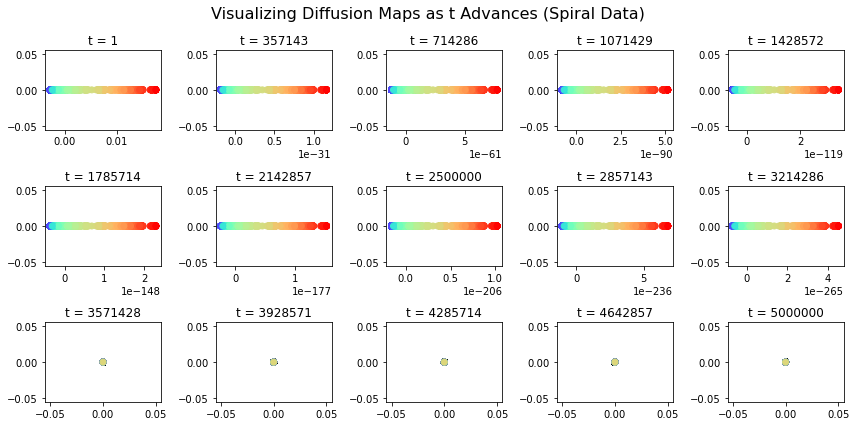

In [187]:
t_values = np.linspace(1, 5000000, 15, dtype=np.int32)
fig, axs = plt.subplots(3, 5, figsize = (12,6))
for i , ax in enumerate(axs.flatten()):
    diffusion_map_trunc = diffmap(spiral, sigma = 1, t = t_values[i], m = 1)
    ax.scatter(diffusion_map_trunc[:], [0]*diffusion_map_trunc.shape[0],c=thetas,cmap ='rainbow')
    ax.axis('on')
    ax.set_title('t = ' + str(t_values[i]), fontsize=12)
plt.tight_layout()

In [191]:
print(digits_X.shape)
print(spiral.shape)

(901, 64)
(1000, 2)


### Observations from 